# Ajuste de focos de incêndio com dados do Google Trends

### Augusto, Ana, Marllon e Alexandre
 


### Importando bibliotecas

In [ ]:
!pip install optuna
!pip install pytrends

In [ ]:
#import csv
import pandas as pd
#import missingno as ms
import numpy as np
import matplotlib.pyplot as plt

import sklearn.datasets
import sklearn.model_selection
import sklearn.metrics
import sklearn.ensemble

import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.svm
import sklearn.neighbors

import optuna

from pytrends.request import TrendReq
import time
#startTime = time.time()

#from treeinterpreter import treeinterpreter as ti
#import waterfall_chart

### Lendo os dados:

In [ ]:
df_palavras_Y = pd.read_csv('/content/FrequenciaPantanal v4.csv') #numero de novos focos
df_palavras_X = pd.read_csv('/content/trends2.csv') #dados do google trends (9 meses)

### Visualizando os dados:


In [ ]:
df_all=df_palavras_X.join(df_palavras_Y)

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   253 non-null    object 
 1   incendio na floresta   253 non-null    int64  
 2   queimada               253 non-null    int64  
 3   floresta amazonica     253 non-null    int64  
 4   pantanal               253 non-null    int64  
 5   desmatamento           253 non-null    int64  
 6   brasil em chamas       253 non-null    int64  
 7   queimadas              253 non-null    int64  
 8   fogo                   253 non-null    int64  
 9   bolsonaro              253 non-null    int64  
 10  queimadas no pantanal  253 non-null    int64  
 11  queimadas no brasil    253 non-null    int64  
 12  problema ambiental     253 non-null    int64  
 13  impacto das queimadas  253 non-null    int64  
 14  clima                  253 non-null    int64  
 15  aqueci

In [ ]:
df_all["caso"].describe()

count    253.000000
mean      81.378722
std      107.641144
min        0.400000
25%       12.800000
50%       28.800000
75%      109.600000
max      577.200000
Name: caso, dtype: float64

In [ ]:
df_all.corr()["caso"].sort_values(ascending=False)

caso                     1.000000
umidade do ar            0.764927
queimada                 0.558601
incendio no pantanal     0.542917
umidade                  0.539413
queimadas                0.528644
queimadas no pantanal    0.519415
incendios                0.489168
pantanal                 0.480370
queimadas no brasil      0.459348
calor                    0.410659
brasil em chamas         0.363242
desmatamento             0.354944
umidade relativa         0.324785
impacto das queimadas    0.291252
bioma                    0.286904
salve o pantanal         0.264749
cerrado                  0.234978
fogo                     0.203270
floresta amazonica       0.192583
temperatura              0.187278
clima                    0.186880
biomas brasileiros       0.161074
problema ambiental       0.128349
aquecimento global       0.100590
incendio na floresta     0.096787
fuligem                  0.087215
mato grosso              0.085640
chuva no pantanal        0.058344
chuva pantanal

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff43eec6748>,
      dtype=object)

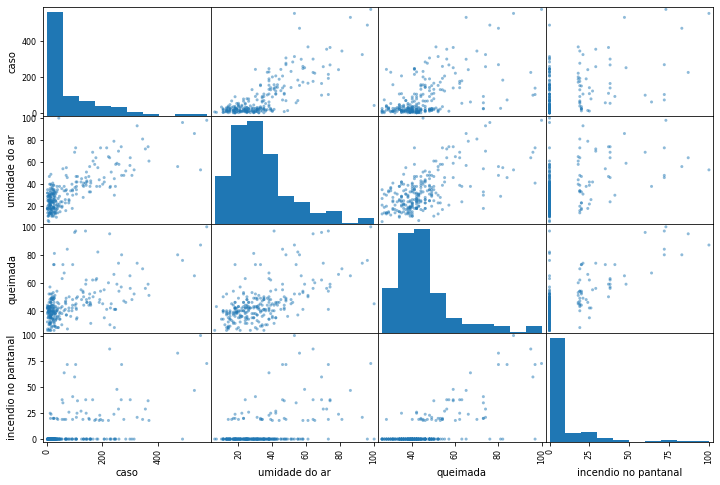

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["caso", "umidade do ar", "queimada",
              "incendio no pantanal"]
scatter_matrix(df_all[attributes], figsize=(12, 8))

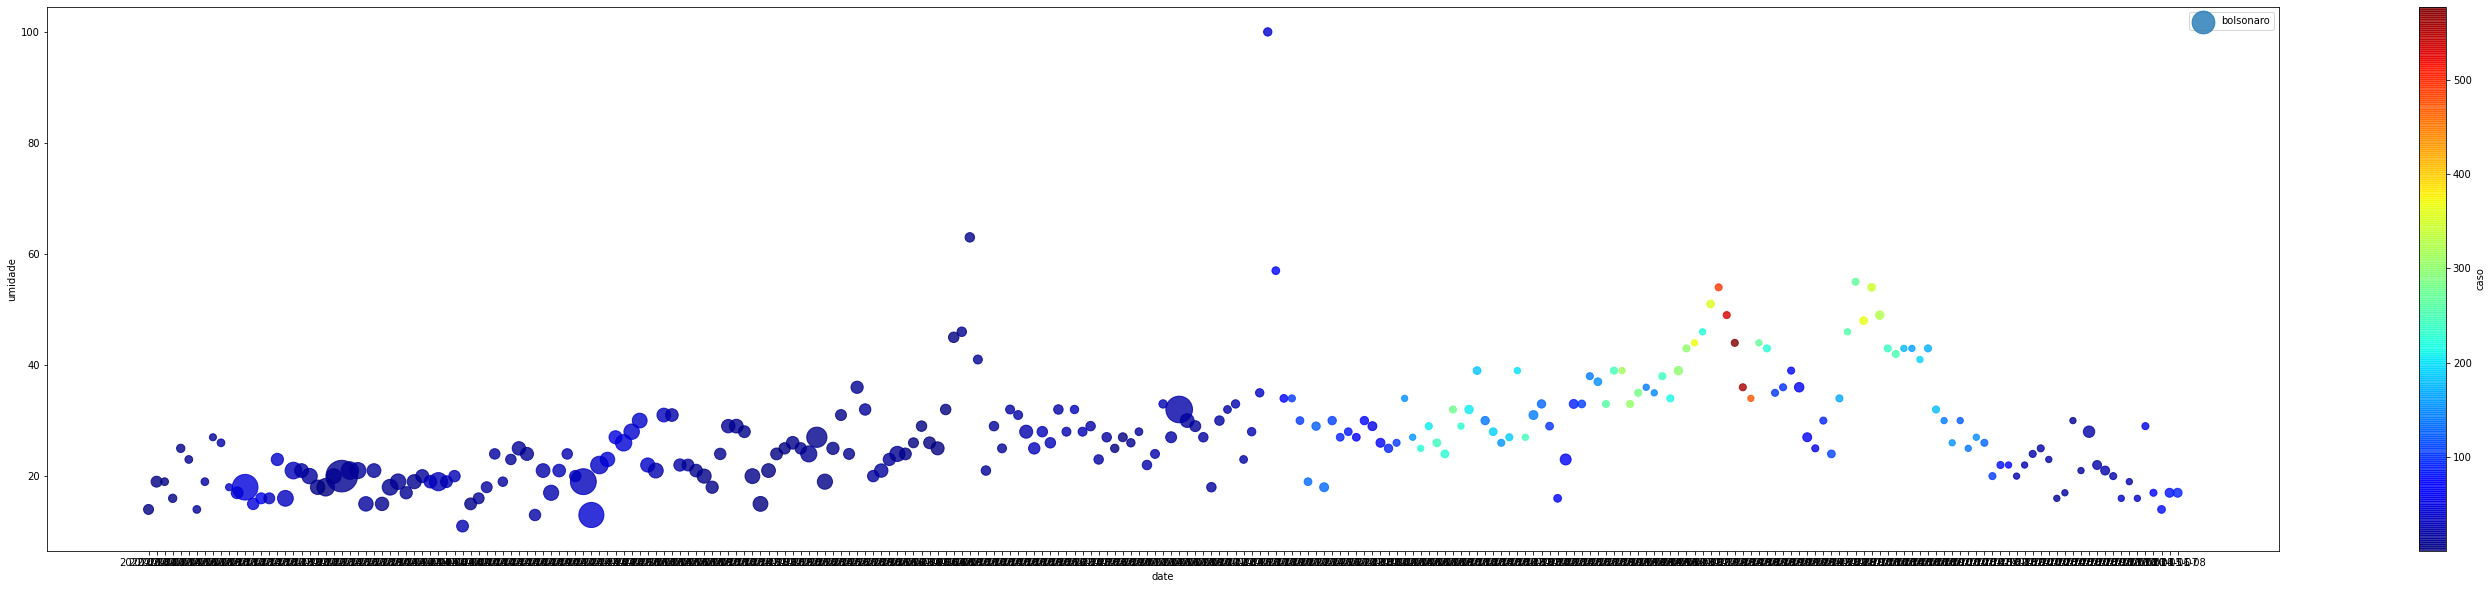

In [ ]:
#df_all.plot(kind="scatter", x="date", y="umidade")
df_all.plot(kind="scatter", x="date", y="umidade", alpha=0.8,
    s=df_all["bolsonaro"]*10, label="bolsonaro", figsize=(50,10),
    c="caso", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False) #sharex=false é só pra corrigir um bug de display https://github.com/pandas-dev/pandas/issues/10611
plt.legend()

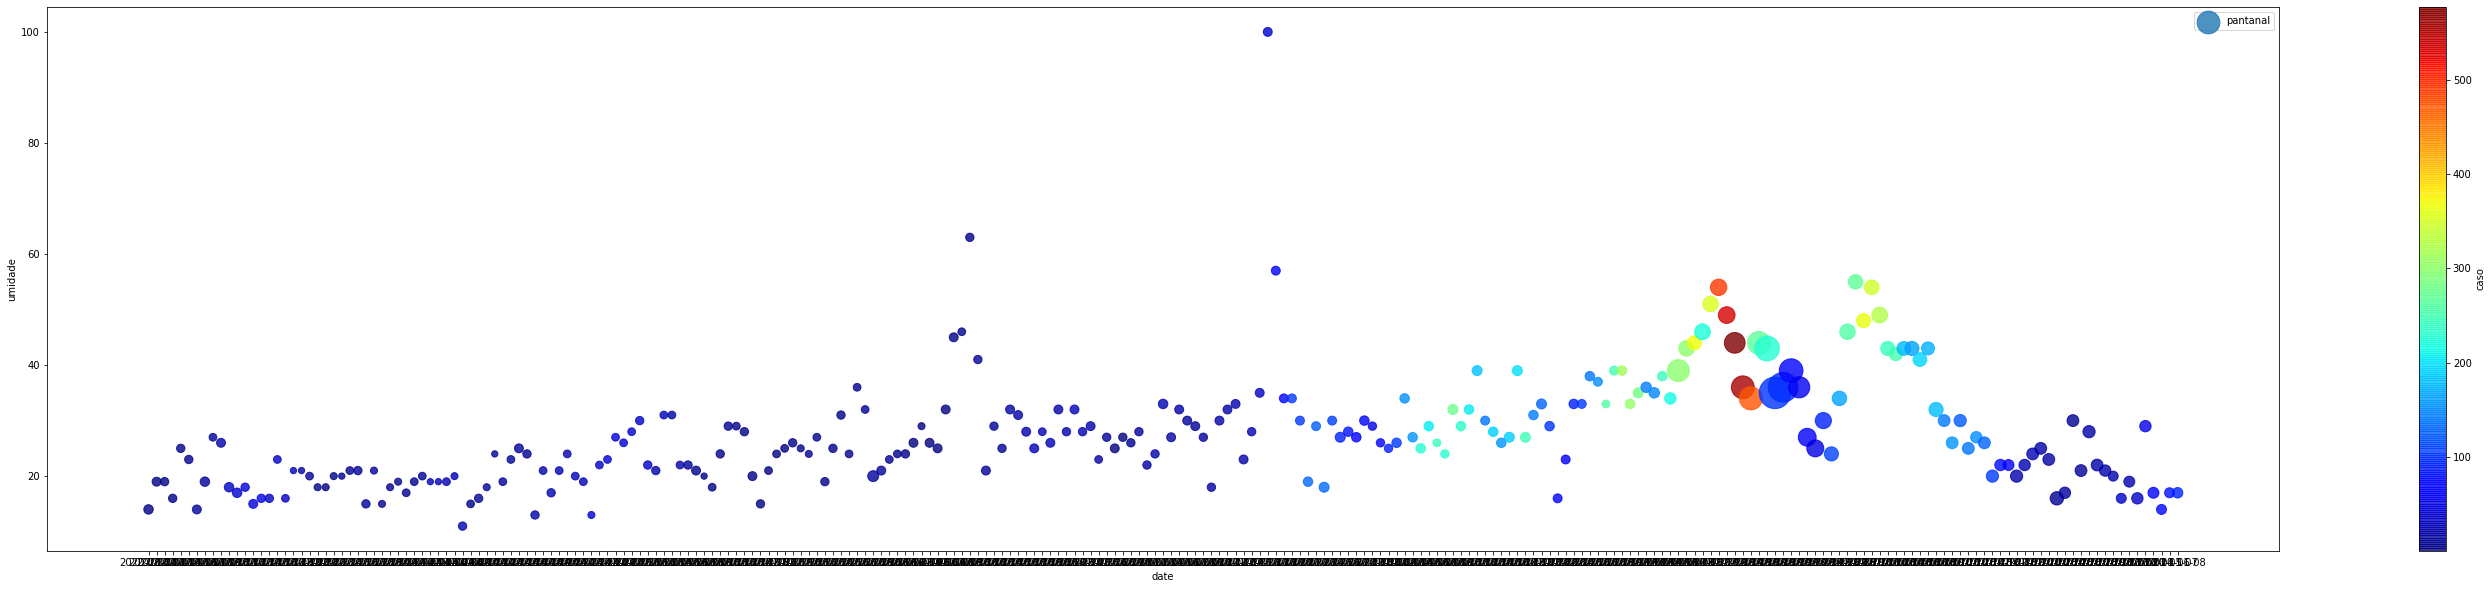

In [ ]:
#df_all.plot(kind="scatter", x="date", y="umidade")
df_all.plot(kind="scatter", x="date", y="umidade", alpha=0.8,
    s=df_all["pantanal"]*10, label="pantanal", figsize=(50,10),
    c="caso", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False) #sharex=false é só pra corrigir um bug de display https://github.com/pandas-dev/pandas/issues/10611
plt.legend()

### Funções que serão usadas:

In [ ]:
#Pré-processamento:
def pre_process (df):
    
    new_df = pd.DataFrame()
    
    for n,c in df.items():
                
        if pd.api.types.is_numeric_dtype(c):
            # substituindo NaN numericos pelas medianas de cada coluna
            new_df[n] = c.fillna(value=c.median())
        else:
            # interpretando o que nao for numerico como variaveis categoricas 
            # e transformando cada categoria em um numero
            new_df[n] = pd.Categorical(c.astype('category').cat.as_ordered()).codes
    
    return new_df  

#métrica de treino:
def rmse(x,y): 
    
    return np.sqrt(sklearn.metrics.mean_squared_error(x,y))

#Imprime métrica de treino:
def display_score(m):
    
    res = [[rmse(m.predict(X_treino), y_treino), m.score(X_treino, y_treino)],
          [rmse(m.predict(X_validacao), y_validacao), m.score(X_validacao, y_validacao)]]
    
    score = pd.DataFrame(res, columns=['RMSE','R2'], index = ['Treino','Validação'])
    
    if hasattr(m, 'oob_score_'): 
        score.loc['OOB'] = [rmse(y_treino, m.oob_prediction_), m.oob_score_]
        
    return score

# Importâncias das variáveis:
def plotar_importancias(modelo, tags, n=10):
    
    fig, ax = plt.subplots(1,2, figsize = (20,4))

    coefs = []
    abs_coefs = []

    if hasattr(modelo,'coef_'):
        imp = modelo.coef_
    elif hasattr(modelo,'feature_importances_'):
        imp = modelo.feature_importances_
    else:
        print('sorry, nao vai rolar!')
        return

    coefs = (pd.Series(imp, index = tags))
    coefs.plot(use_index=False, ax=ax[0]);
    abs_coefs = (abs(coefs)/(abs(coefs).sum()))
    abs_coefs.sort_values(ascending=False).plot(use_index=False, ax=ax[1],marker='.')

    ax[0].set_title('Importâncias relativas das variáveis')
    ax[1].set_title('Importâncias relativas das variáveis - ordem decrescente')

    abs_coefs_df = pd.DataFrame(np.array(abs_coefs).T,
                                columns = ['Importancias'],
                                index = tags)

    df = abs_coefs_df['Importancias'].sort_values(ascending=False)
    
    print(df.iloc[0:n])
    plt.figure()
    df.iloc[0:n].plot(kind='barh', figsize=(15,0.25*n), legend=False)
    
    return df



# Dendograma:
def dendogram_spearmanr(df, tags):

    import scipy.cluster.hierarchy
    import scipy.stats
    
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = scipy.cluster.hierarchy.distance.squareform(1-corr)
    z = scipy.cluster.hierarchy.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(18,8))
    dendrogram = scipy.cluster.hierarchy.dendrogram(z, labels=tags, orientation='left', leaf_font_size=30)
    plt.show()
    



### Treinando e validando:

Salvando X e Y e dividindo entre treino e teste:

In [ ]:
y = df_palavras_Y.caso

df_palavras_X_pre = pre_process(df_palavras_X)
X = df_palavras_X_pre
X = df_palavras_X_pre.drop(['mato grosso','fogo','fuligem','clima','queimadas','chuva no pantanal',
                            'chuva pantanal','impacto das queimadas','umidade do ar','queimadas no pantanal',
                            'queimada','desmatamento','queimadas no brasil','brasil em chamas',
                            'calor','aquecimento global','floresta amazonica','biomas brasileiros',
                            'bioma','temperatura','meio ambiente','salve o pantanal','incendio na floresta'], axis=1)





Separando variáveis de treino e validação

In [ ]:
X_treino, X_validacao, y_treino, y_validacao = sklearn.model_selection.train_test_split(X, y, test_size = 0.1, random_state = 0)
#X_treino, X_validacao, y_treino, y_validacao = sklearn.model_selection.train_test_split(X, y, test_size = 0.25, shuffle=False, stratify=None)

Treinando:

In [ ]:
m = sklearn.ensemble.RandomForestRegressor(n_jobs=-1, oob_score = True, random_state = 0)
#m = sklearn.ensemble.RandomForestRegressor(n_estimators = 100, n_jobs=-1, oob_score = True, random_state = 0)
#m = sklearn.ensemble.RandomForestRegressor(max_depth=400, min_samples_leaf = 1, max_features = 0.4, n_jobs=-1, oob_score = True, random_state = 0)
m.fit(X_treino, y_treino)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=0, verbose=0, warm_start=False)

Validando:

In [ ]:

y_validacao_pred = m.predict(X_validacao)

sc=display_score(m)
sc

,RMSE,R2
Treino,16.366036,0.976683
Validação,45.489462,0.824920
OOB,49.442844,0.787192


Importâncias e dendograma:

date                    0.429135
umidade                 0.304258
pantanal                0.111182
chuva                   0.038165
incendio no pantanal    0.033869
incendios               0.031115
problema ambiental      0.015542
umidade relativa        0.013955
cerrado                 0.013538
bolsonaro               0.009242
Name: Importancias, dtype: float64


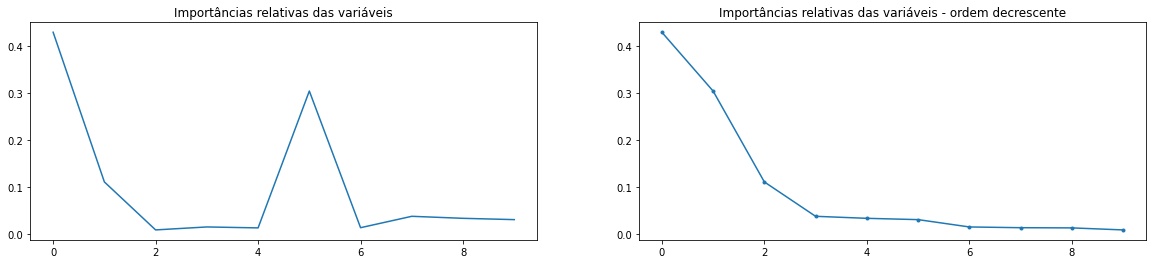

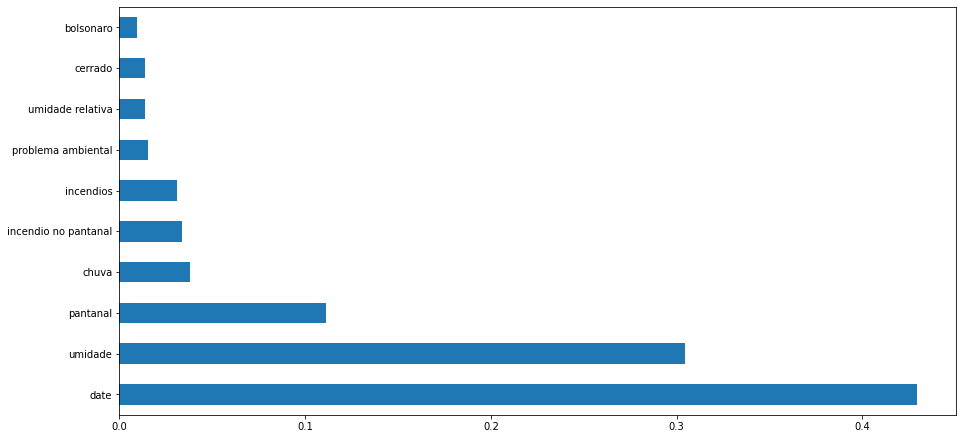

In [ ]:
imp3 = plotar_importancias(m, X_treino.columns,30) #treino


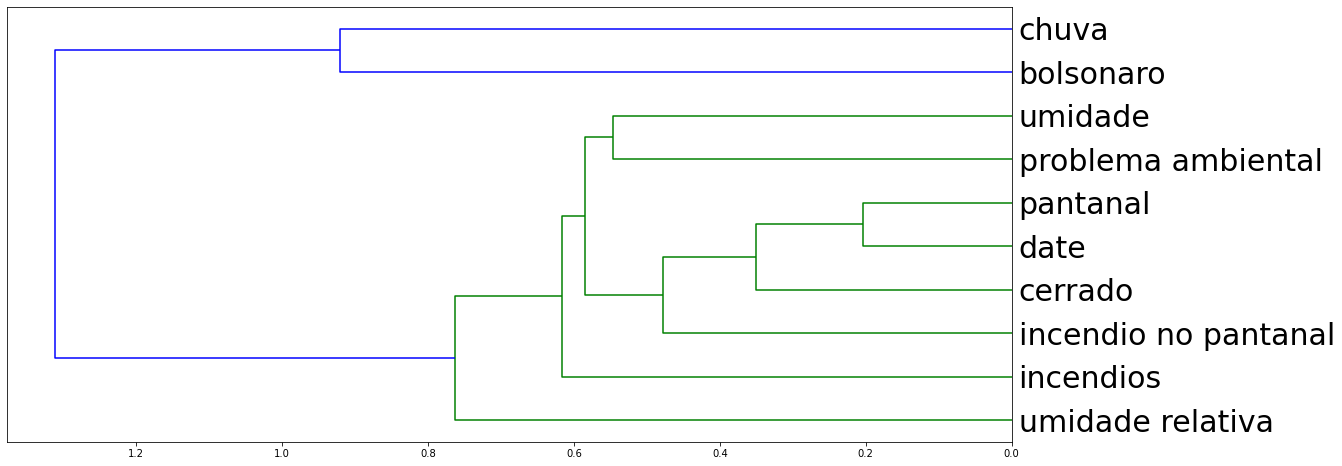

In [ ]:
dendogram_spearmanr(X_treino, X_treino.columns)





### Validação cruzada:

In [ ]:
m2 = sklearn.ensemble.RandomForestRegressor(min_samples_leaf = 3, max_features = 0.6, 
                                            n_estimators = 60, n_jobs=-1, oob_score = True, 
                                            random_state = 0)

results = sklearn.model_selection.cross_val_score(m2, X_treino, y_treino, scoring='r2')
results



array([0.77827834, 0.76376869, 0.65771357, 0.86282254, 0.82013282])

In [ ]:
results.mean()


0.7765431945452281

### Comparando modelos

Modelo: média, desvio-padrão
-------------------
LinearRegression: 0.104, 1.09
MLPRegressor: 0.4, 0.26
RandomForestRegressor: 0.766, 0.13
KNeighborsRegressor: 0.594, 0.13
SVR: 0.03, 0.169


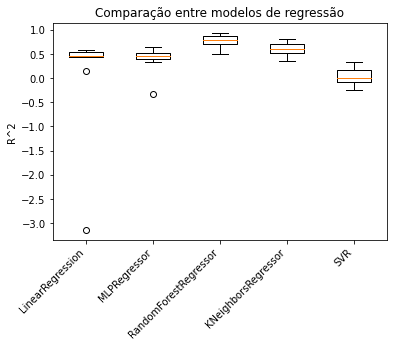

In [ ]:
# especificando modelos 

modelos = [sklearn.linear_model.LinearRegression(),
           sklearn.neural_network.MLPRegressor(),
           sklearn.ensemble.RandomForestRegressor(),
           sklearn.neighbors.KNeighborsRegressor(),
           sklearn.svm.SVR()]


#lista para guardar resultados
results = [0]*len(modelos)

print('Modelo: média, desvio-padrão\n-------------------')

for i in range(len(modelos)):
    
    # efetuando a validação cruzada!
    results[i] = sklearn.model_selection.cross_val_score(modelos[i], 
                                                         X_treino, y_treino, 
                                                         cv=10, 
                                                         scoring='r2',
                                                         n_jobs=-1)
    
    # imprimindo resultados
    print(f'{modelos[i].__class__.__name__}: {results[i].mean():.3}, {results[i].std():.3}')

# plotando resultados
fig, ax = plt.subplots()
ax.boxplot(results)

# formatando gráfico
ax.set_xticklabels([modelos[i].__class__.__name__ for i in range(len(modelos))], 
                   rotation = 45, ha="right")
ax.set_ylabel("R^2")
ax.set_title('Comparação entre modelos de regressão');

In [ ]:
print('R^2\n--------------')

for m in modelos:
    m.fit(X_treino, y_treino)
    print(f'{m.__class__.__name__}: {sklearn.metrics.r2_score(y_validacao, m.predict(X_validacao)):.3}')

R^2
--------------
LinearRegression: 0.493


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPRegressor: 0.538
RandomForestRegressor: 0.741
KNeighborsRegressor: 0.722
SVR: -0.068


### Curvas de aprendizado

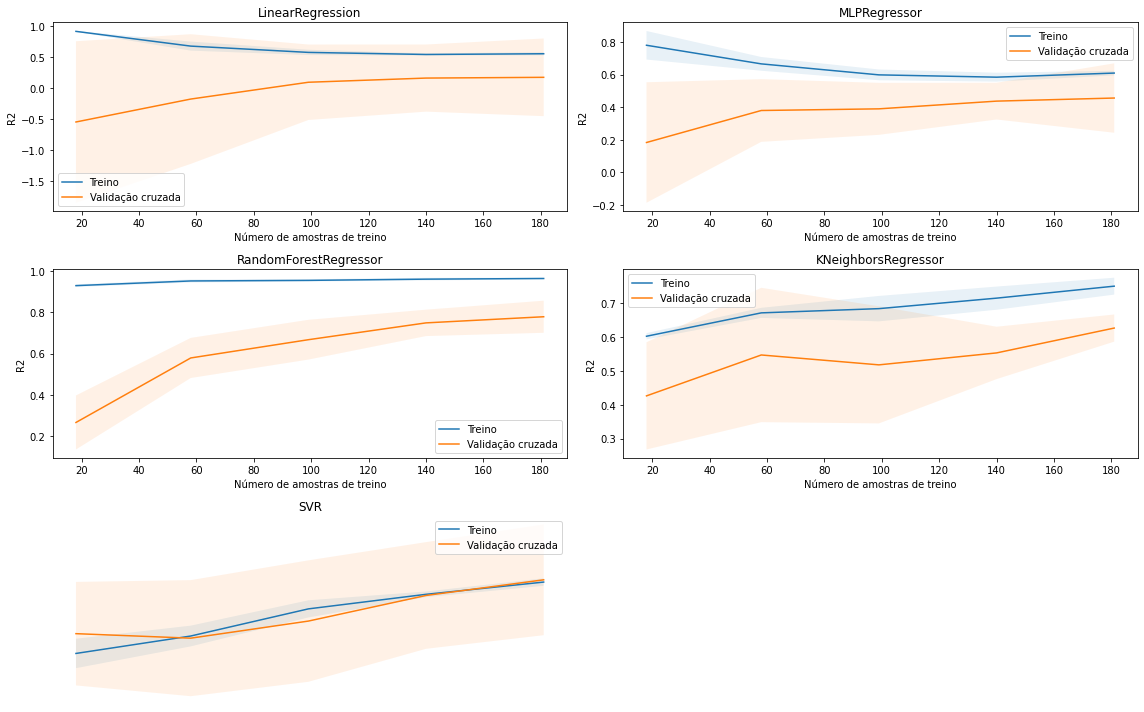

In [ ]:
# adaptado de https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

# especificando modelos 

modelos = [sklearn.linear_model.LinearRegression(),
           sklearn.neural_network.MLPRegressor(),
           sklearn.ensemble.RandomForestRegressor(),
           sklearn.neighbors.KNeighborsRegressor(),
           sklearn.svm.SVR()]


fig, ax = plt.subplots(3,2,figsize=(16,10))

for i in range(len(modelos)):
    
    # calculando a curva de aprendizado!
    train_sizes, train_scores, test_scores = sklearn.model_selection.learning_curve(modelos[i], 
                                                                                    X_treino, y_treino, 
                                                                                    cv=5, 
                                                                                    scoring='r2',
                                                                                    n_jobs=-1)
    
    # médias e desvios-padrão dos resultados da validação cruzada (para cada ponto da curva)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # plotando curva correspondente ao treino
    ax.ravel()[i].plot(train_sizes, train_scores_mean, label="Treino")
    ax.ravel()[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                               train_scores_mean + train_scores_std, alpha=0.1)
    
    # plotando curva correspondente ao teste
    ax.ravel()[i].plot(train_sizes, test_scores_mean, label="Validação cruzada")
    ax.ravel()[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                               test_scores_mean + test_scores_std, alpha=0.1)
    
    # formatando gráfico
    ax.ravel()[i].set_title(modelos[i].__class__.__name__)
    ax.ravel()[i].set_ylabel('R2')
    ax.ravel()[i].set_xlabel('Número de amostras de treino')
    ax.ravel()[i].legend(loc="best")
    
ax.ravel()[-2].axis('off')
ax.ravel()[-1].axis('off')

fig.tight_layout();

### Sintonização de hiperparâmetros

#### Curvas de validação

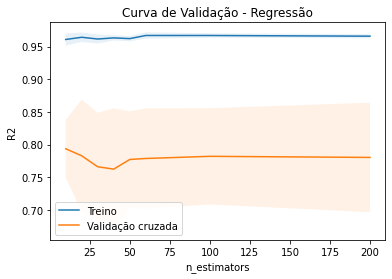

In [ ]:
# adaptado de https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html

# definindo os valores de parâmetros a serem testados
param_range = [10, 20, 30, 40, 50, 60, 100, 200]

# definindo o modelo
m = sklearn.ensemble.RandomForestRegressor()

# calculando a curva de validação!
train_scores, test_scores = sklearn.model_selection.validation_curve(m, X_treino, y_treino, 
                                                                     param_name="n_estimators", 
                                                                     param_range=param_range,
                                                                     scoring="r2", 
                                                                     n_jobs=-1)

# médias e desvios-padrão dos resultados da validação cruzada (para cada ponto da curva)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plotando curva correspondente ao treino
plt.plot(param_range, train_scores_mean, label="Treino")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)

# plotando curva correspondente ao teste
plt.plot(param_range, test_scores_mean, label="Validação cruzada")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1)

# formatando gráfico
plt.title("Curva de Validação - Regressão")
plt.xlabel('n_estimators')
plt.ylabel("R2")
plt.legend(loc="best");

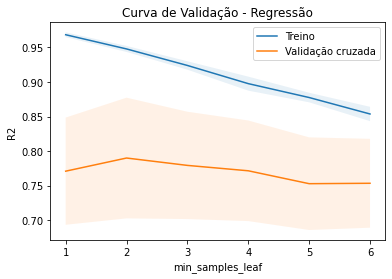

In [ ]:
# definindo os valores de parâmetros a serem testados
param_range = [1, 2, 3, 4, 5, 6]

# definindo o modelo
m = sklearn.ensemble.RandomForestRegressor()

# calculando a curva de validação!
train_scores, test_scores = sklearn.model_selection.validation_curve(m, X_treino, y_treino, 
                                                                     param_name="min_samples_leaf", 
                                                                     param_range=param_range,
                                                                     scoring="r2", 
                                                                     n_jobs=-1)

# médias e desvios-padrão dos resultados da validação cruzada (para cada ponto da curva)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plotando curva correspondente ao treino
plt.plot(param_range, train_scores_mean, label="Treino")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)

# plotando curva correspondente ao teste
plt.plot(param_range, test_scores_mean, label="Validação cruzada")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1)

# formatando gráfico
plt.title("Curva de Validação - Regressão")
plt.xlabel('min_samples_leaf')
plt.ylabel("R2")
plt.legend(loc="best");

#### Sintonização automática

In [ ]:
# função objetivo para otimização de hiperparâmetros
def objetivo(trial):

    # colocaremos dois modelos pra brigar: KNeighborsRegressor e RF
    
    sklearn.neighbors.KNeighborsRegressor
    
    classifier_name = trial.suggest_categorical("classifier", ["KNeighborsRegressor", "RandomForest"])
    
    if classifier_name == 'KNeighborsRegressor':
        # hiperparâmetros de busca
        rf_leaf_size = trial.suggest_int("rf_leaf_size", 1, 10)
        rf_p = trial.suggest_int("rf_p", 1, 3)
                
        # modelo
        m = sklearn.neighbors.KNeighborsRegressor(leaf_size = rf_leaf_size, 
                                                  p = rf_p)

        
    else:

        # hiperparâmetros de busca para o RF
        rf_min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 1, 10)
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log = True)
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10,100)
        
        # modelo RF
        m = sklearn.ensemble.RandomForestRegressor(max_depth = rf_max_depth, 
                                                   min_samples_leaf = rf_min_samples_leaf, 
                                                   n_estimators = rf_n_estimators)

    # retornando R2
    R2 = sklearn.model_selection.cross_val_score(m, X_treino, y_treino, n_jobs = -1, cv = 3, scoring='r2')
    R2 = R2.mean()
    return R2


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objetivo, n_trials = 100)

[I 2021-02-11 14:40:47,616] A new study created in memory with name: no-name-f5a82935-876c-47af-8a81-24ba352e1a75
[I 2021-02-11 14:40:47,650] Trial 0 finished with value: 0.6525781218417227 and parameters: {'classifier': 'KNeighborsRegressor', 'rf_leaf_size': 10, 'rf_p': 2}. Best is trial 0 with value: 0.6525781218417227.
[I 2021-02-11 14:40:47,795] Trial 1 finished with value: 0.7430925960404037 and parameters: {'classifier': 'RandomForest', 'rf_min_samples_leaf': 2, 'rf_max_depth': 31, 'rf_n_estimators': 26}. Best is trial 1 with value: 0.7430925960404037.
[I 2021-02-11 14:40:47,822] Trial 2 finished with value: 0.68302445442225 and parameters: {'classifier': 'KNeighborsRegressor', 'rf_leaf_size': 10, 'rf_p': 1}. Best is trial 1 with value: 0.7430925960404037.
[I 2021-02-11 14:40:47,849] Trial 3 finished with value: 0.6525781218417227 and parameters: {'classifier': 'KNeighborsRegressor', 'rf_leaf_size': 8, 'rf_p': 2}. Best is trial 1 with value: 0.7430925960404037.
[I 2021-02-11 14:4

In [ ]:
study.best_params

{'classifier': 'RandomForest',
 'rf_max_depth': 25,
 'rf_min_samples_leaf': 3,
 'rf_n_estimators': 44}

In [ ]:
m = sklearn.ensemble.RandomForestRegressor(max_depth = study.best_params['rf_max_depth'],
                                           min_samples_leaf = study.best_params['rf_min_samples_leaf'],
                                           n_estimators = study.best_params['rf_n_estimators'])
R2 = sklearn.model_selection.cross_val_score(m, X_treino, y_treino, n_jobs = -1, cv = 3, scoring='r2')
R2 = R2.mean()
print(R2)

0.7736754701837576


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_contour(study, params=['rf_max_depth','rf_min_samples_leaf','rf_n_estimators'])

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_slice(study)